**CALL CENTER OPERATIONS ANALYTICS** <br>

Author Diana Kung'u

Questions:
1. Number/proposition of Calls per Reason <br>
     - summary numbers
2. Call Center activity peak analysis <br> 
     - Distribution of Calls by day of week/month and hour of day
     
3. Queue Analysis <br> 
     - Abandonment rate <br>

     - Estimate number of potential customers lost.

     - Wait Duration <br>
4. Schedule Optimization <br> 
     - Utilization rate/idle time <br>
     - Incoming calls

5. Agent Performance


In [2]:
# Load libraries
import pandas as pd

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
sns.set(style='white')

In [3]:

#Read data
#.............................................................................................
chunks = pd.read_csv(r'.\Data\call center.csv', parse_dates=['Call Date Time'], chunksize= 5000)
call_df = pd.concat(chunks, ignore_index= True)

In [4]:
df = call_df.copy()
df.head(3)

,Abandon Flag,Agent,Agent Selection Group,Call #,Call Date Time,Call Reason,Customer,First Contact Resolution Flag,Talk Time (s),Wait Time (s)
0,N,Anabel Grebert,Other,3800023,2021-11-30 09:46:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,143,5
1,N,Anabel Grebert,Other,3796097,2021-11-29 08:21:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,38,6
2,N,Anabel Grebert,Other,3772171,2021-11-18 10:20:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,54,6


**Data Preparation**


In [5]:
#Split call date and time fields
Call_Date, Call_Time= zip(*[(d.date(), d.time()) for d in df['Call Date Time']])
df['Call Date'], df['Call Time'] =[Call_Date, Call_Time]

#Format Date and time columns to datetime objects
df['Call Date'] = pd.to_datetime(df['Call Date'], format='%Y-%m-%d')
df['Call Time'] = df['Call Time'].apply(lambda x: x.strftime('%H:%M'))
df.head(2)

,Abandon Flag,Agent,Agent Selection Group,Call #,Call Date Time,Call Reason,Customer,First Contact Resolution Flag,Talk Time (s),Wait Time (s),Call Date,Call Time
0,N,Anabel Grebert,Other,3800023,2021-11-30 09:46:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,143,5,2021-11-30,09:46
1,N,Anabel Grebert,Other,3796097,2021-11-29 08:21:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,38,6,2021-11-29,08:21


In [6]:
# Parse the Year, Month Day, and hour of each call
df['Year'] = df['Call Date'].dt.year
df['Month'] = df['Call Date'].dt.month
df['Day of Week'] = [d.strftime("%A") for d in df['Call Date']]
df['Hour'] =  df['Call Date Time'].dt.hour
df['Day'] = df['Call Date'].dt.day
df.head(3)


,Abandon Flag,Agent,Agent Selection Group,Call #,Call Date Time,Call Reason,Customer,First Contact Resolution Flag,Talk Time (s),Wait Time (s),Call Date,Call Time,Year,Month,Day of Week,Hour,Day
0,N,Anabel Grebert,Other,3800023,2021-11-30 09:46:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,143,5,2021-11-30,09:46,2021,11,Tuesday,9,30
1,N,Anabel Grebert,Other,3796097,2021-11-29 08:21:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,38,6,2021-11-29,08:21,2021,11,Monday,8,29
2,N,Anabel Grebert,Other,3772171,2021-11-18 10:20:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,54,6,2021-11-18,10:20,2021,11,Thursday,10,18


In [7]:
#Duplicated Call #
df.drop_duplicates(keep='first', inplace= True)
#df[df.duplicated(['Call #'])]
df.drop_duplicates('Call #', keep='first', inplace= True)

In [26]:
# Bin Wait time
wait_bin = [0, 30, 90, 180, 300, 10000]
wait_bin_labels = ['<30s', '30-90s', '91-180s', '181-300s', '>300s']
df['Wait Time Bins'] = pd.cut(df['Wait Time (s)'], bins= wait_bin, labels= wait_bin_labels)

In [30]:
talk_bin = [0, 60, 180, 300, 480, 10000]
talk_bin_labels = ['<1 min', '1 -3 mins', '3- 5 mins', '5 - 8 mins', '>8 mins']
df['Talk Time Bins'] = pd.cut(df['Talk Time (s)'], bins= talk_bin, labels= talk_bin_labels)
df['Talk Time Bins'].value_counts()

1 -3 mins     81598
3- 5 mins     67296
5 - 8 mins    40947
<1 min        27642
>8 mins       22990
Name: Talk Time Bins, dtype: int64

1. ## Summary Analysis<br>

What is the number/proportion of incoming calls per reason. <br>
Total number of agents <br>
Total number of customers <br>
Number of incoming calls. <br>

1. Frequency of Calls by reason

In [10]:
# Unique call reasons
reasons  = df['Call Reason'].unique().tolist()
#Frequency of each reason
df_reasons = df.groupby(['Call Reason']).agg(No_Calls =('Call #', 'count')).reset_index()
df_reasons['Proportion'] =df_reasons['No_Calls']*100/df_reasons['No_Calls'].sum()
df_reasons['Proportion %'] = df_reasons['Proportion'].map('{:,.1f}%'.format)
df_reasons

,Call Reason,No_Calls,Proportion,Proportion %
0,Billing Questions,53107,22.061548,22.1%
1,Internet Outage,69534,28.885602,28.9%
2,New Customer,5580,2.318027,2.3%
3,Other,889,0.369306,0.4%
4,Product/Service Problems,20950,8.702985,8.7%
5,Technical Issues,90662,37.662532,37.7%


<AxesSubplot:title={'center':'Proportion of Calls per Reason'}, xlabel='Call Reason', ylabel='Proportion'>

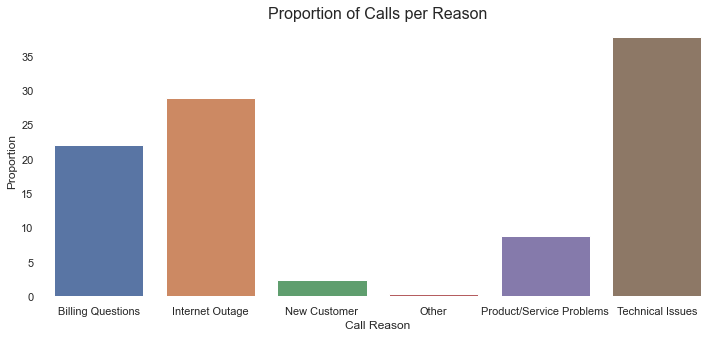

In [11]:
plt.figure(figsize=(12,5))
plt.title('Proportion of Calls per Reason', fontsize = 16)

sns.despine(bottom = True, left = True)
sns.barplot(x = 'Call Reason', y = 'Proportion', data = df_reasons)


Technical Issues, Internet Outages and Billing Questions account for the largest number
of calls.

2. **Call Center activity: Peak Analysis** <br>

   I. Day of month/week

Number of calls per reason by day/day of week are evenly distributed.

In [12]:
df_day_distribution = df.groupby(['Call Reason', 'Day of Week']).agg(No_Calls =('Call #', 'count')).reset_index()
df_day_distribution.head(2)

,Call Reason,Day of Week,No_Calls
0,Billing Questions,Friday,8815
1,Billing Questions,Monday,10712


In [13]:
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df_day_distribution['Day of Week'] = (pd.Categorical(df_day_distribution['Day of Week'], 
                                                     categories=ordered_days, ordered=True))
df_day_distribution['Day of Week'].sort_index(inplace= True)

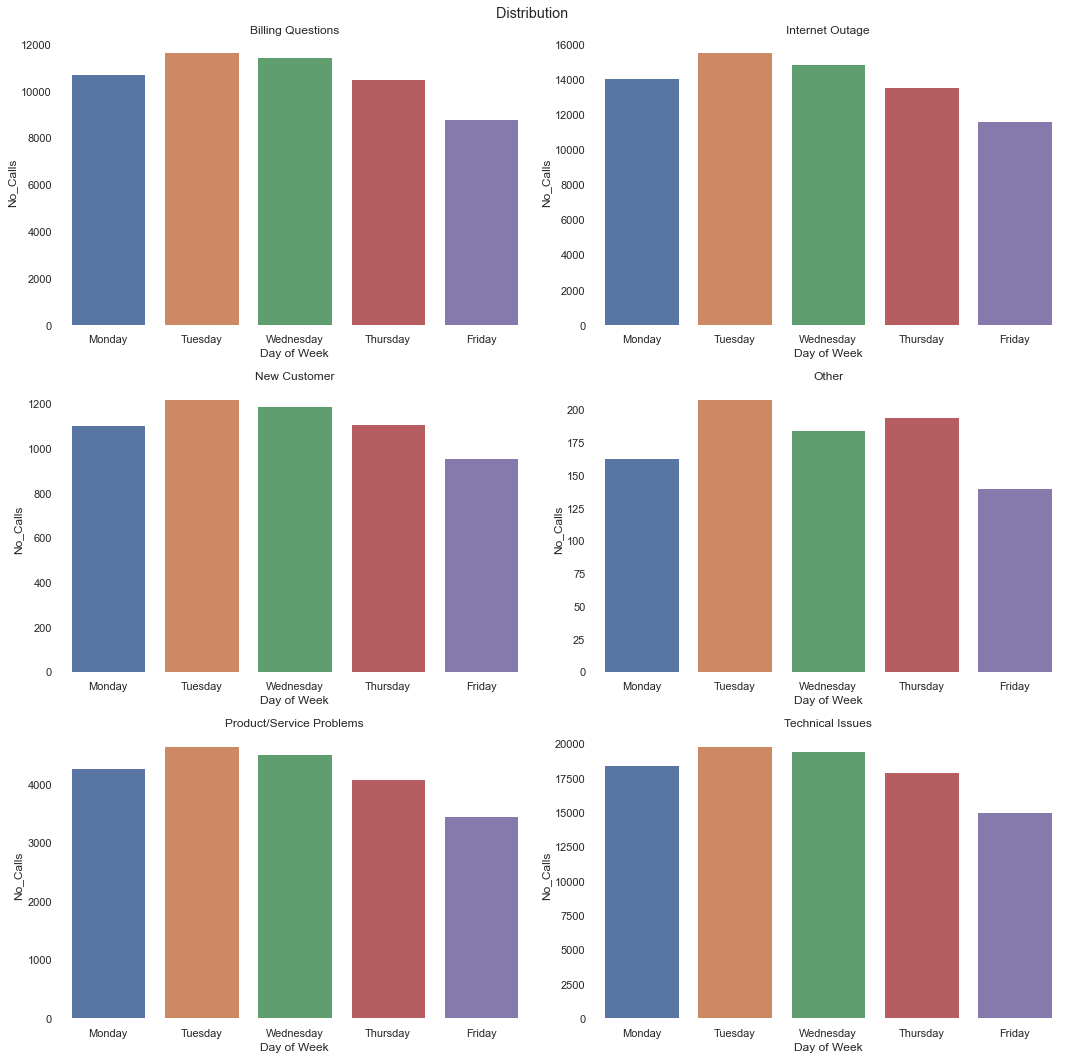

In [14]:
figure, axis = plt.subplots(3, 2,figsize=(15, 15), facecolor='w', edgecolor='k')

a = 3 #rows
b = 2 # columns
c = 1 # subplot iterator

for i in df_day_distribution['Call Reason'].unique():
    plt.subplot(a, b, c)
    plt.title(f'{i}')
    plt.xlabel(i)
    plt.suptitle('Distribution ')
    plt.ylabel('')
    plt.xlabel('')

    #cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.barplot(x = 'Day of Week', y = 'No_Calls', data = df_day_distribution[df_day_distribution['Call Reason'] == i])
    sns.despine(bottom = True, left = True)
    c = c + 1
plt.tight_layout()                

In [15]:
#Distribution by hour and day of week
#Heatmap 
daily_dist = df[df['Year'] ==2021].groupby(['Day of Week','Hour']).agg(
                                No_Calls =('Call #', 'count'),
                                No_days = ('Call Date', 'nunique'),
                                No_staff = ('Agent', 'nunique')).reset_index()
daily_dist['Average Calls per Day_hour'] = (daily_dist['No_Calls']/ daily_dist['No_days']).astype(int)
daily_dist

,Day of Week,Hour,No_Calls,No_days,No_staff,Average Calls per Day_hour
0,Friday,8,570,48,23,11
1,Friday,9,2126,48,28,44
2,Friday,10,2752,48,29,57
3,Friday,11,3045,47,29,64
4,Friday,12,2568,48,29,53
...,...,...,...,...,...,...
58,Wednesday,15,3290,50,28,65
59,Wednesday,16,2595,50,28,51
60,Wednesday,17,441,46,20,9
61,Wednesday,18,67,6,5,11


In [16]:
# Staff distribution per day of week
daily_dist.pivot_table(index= 'Day of Week', columns= 'Hour', 
                                   values = 'No_staff', aggfunc='first', fill_value=0)

Hour,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Day of Week,,,,,,,,,,,,,,
Friday,0,23,28,29,29,29,29,29,28,27,18,4,2,0
Monday,1,24,27,28,29,28,29,29,28,28,17,4,3,1
Thursday,0,23,28,29,29,29,29,29,28,27,20,7,2,0
Tuesday,0,26,28,29,29,29,29,29,28,27,19,3,2,0
Wednesday,1,23,28,29,29,29,29,29,28,28,20,5,4,0


In [17]:
daily_dist = daily_dist.pivot_table(index= 'Day of Week', columns= 'Hour', 
                                   values = 'Average Calls per Day_hour', aggfunc='first', fill_value=0)
daily_dist.index = (pd.Categorical(daily_dist.index, categories=ordered_days, ordered=True))
daily_dist.sort_index(inplace= True)
daily_dist

Hour,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Monday,1,13,47,65,72,65,68,71,69,54,11,10,4,1
Tuesday,0,17,54,68,76,64,67,71,69,53,10,4,4,0
Wednesday,1,17,51,72,77,63,64,65,65,51,9,11,7,0
Thursday,0,14,48,68,72,60,59,65,60,51,9,5,4,0
Friday,0,11,44,57,64,53,56,55,53,38,6,9,2,0


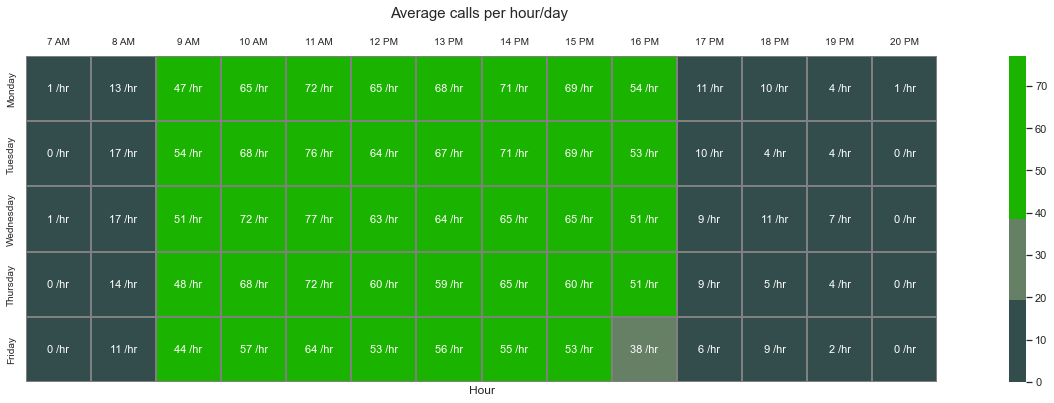

In [18]:

fig,ax = plt.subplots(1,1,figsize=(20,5))
my_colors=[(0.2,0.3,0.3),(0.4,0.5,0.4),(0.1,0.7,0),(0.1,0.7,0)]
xticks = [str(x)+' AM' if x < 12 else str(x)+' PM' for x in daily_dist.columns]

h_map = sns.heatmap(data =daily_dist, cmap=my_colors, xticklabels=xticks, square =True, linecolor= 'gray', 
            linewidth =0.1, annot= True, annot_kws={"size": 11}, ax=ax)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
fig.tight_layout(pad=0.08)

for t in h_map.texts: t.set_text(t.get_text() + " /hr")
plt.ylabel('')
plt.title('Average calls per hour/day ', size =15, y = 1.1)

plt.show()



In [19]:
#Total Incoming call in 2021
total_incoming_calls = len(df[df['Year'] ==2021])

In [20]:
#No. of Agents
no_agents = df[df['Year'] ==2021]['Agent'].nunique()
no_customers = df['Customer'].nunique()